In [3]:
import sys
import os

# Add the parent directory of `notebook/` to sys.path
sys.path.append(os.path.abspath(".."))
import numpy as np
import pandas as pd
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.io.ase import AseAtomsAdaptor
from multiprocessing import Pool, cpu_count
from ase import Atoms
from scipy.interpolate import interp1d

import matplotlib.pyplot as plt
# Load the saved dataframe
df = pd.read_pickle(f"../dataset/symmetrized_permittivity.pkl")

In [18]:
# Interpolation function
energy_min = 0.0
energy_max = 30.0
nstep = 1001
new_x = np.linspace(energy_min, energy_max, nstep, dtype=np.float64)

def interpolate_matrix(matrix, omega, new_grid=new_x):
    """High-precision interpolation of a (N, 3, 3) tensor along the energy axis."""
    omega = np.asarray(omega, dtype=np.float64)
    matrix = np.asarray(matrix, dtype=np.float64)
    
    interp = interp1d(
        omega,
        matrix,
        kind='linear',
        axis=0,
        fill_value=0,  # instead of 0
        bounds_error=False
    )
    return interp(new_grid)  # Returns shape (nstep, 3, 3)
def log_transform_matrix(matrix):
    """
    Apply log transformation to a 3D matrix (N, 3, 3).
    Transform each element: log(abs(value)) and adjust for sign.
    Avoid log(0) by adding a small constant (1e-18).
    """
    return np.sign(matrix) * np.log(np.abs(matrix) + 1e-18)
def exp_transform_matrix(matrix_log):
    """
    Inverse of log transformation: exponentiate back to the original scale.
    """
    return np.sign(matrix_log) * np.exp(np.abs(matrix_log))


# Apply interpolation to imag and real permittivity matrices
df['imag_Permittivity_Matrices_interp'] = [
    # exp_transform_matrix(interpolate_matrix(log_transform_matrix(row['imag_symmetrized_permittivity']),row['omega'])) for _, row in df.iterrows()
    interpolate_matrix(row['imag_symmetrized_permittivity'],row['omega']) for _, row in df.iterrows()
]
df['real_Permittivity_Matrices_interp'] = [
    # exp_transform_matrix(interpolate_matrix(log_transform_matrix(row['imag_symmetrized_permittivity']),row['omega'])) for _, row in df.iterrows()
    interpolate_matrix(row['real_symmetrized_permittivity'],row['omega']) for _, row in df.iterrows()
]

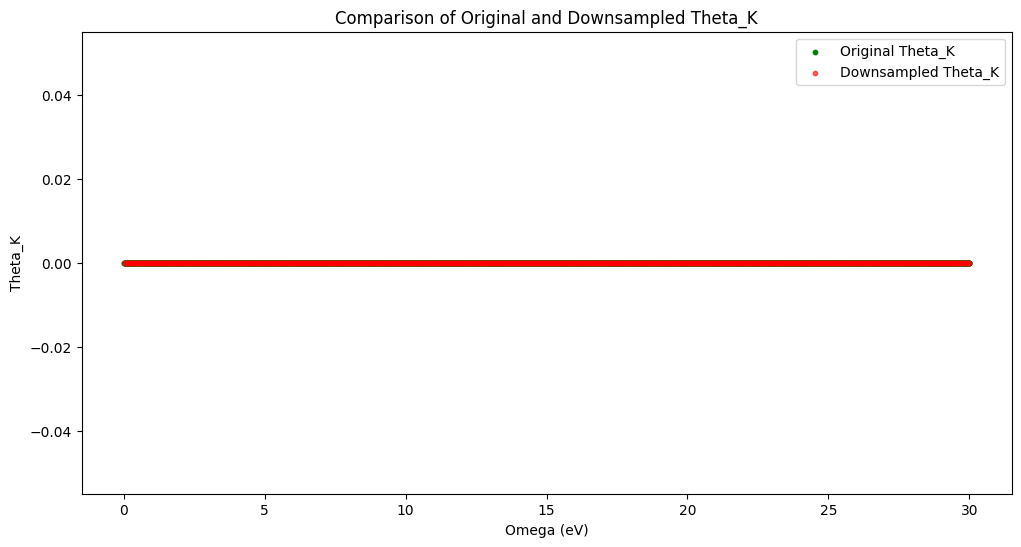

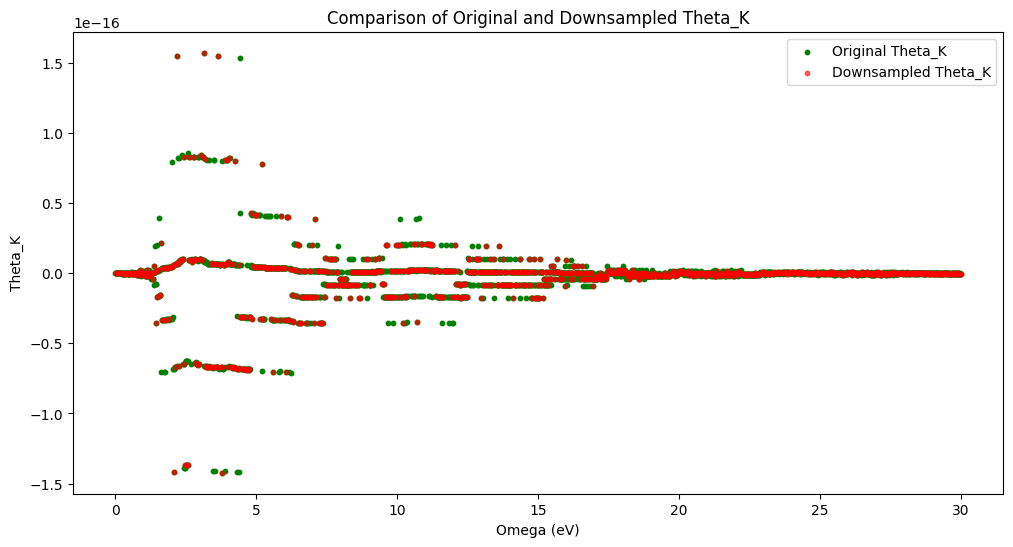

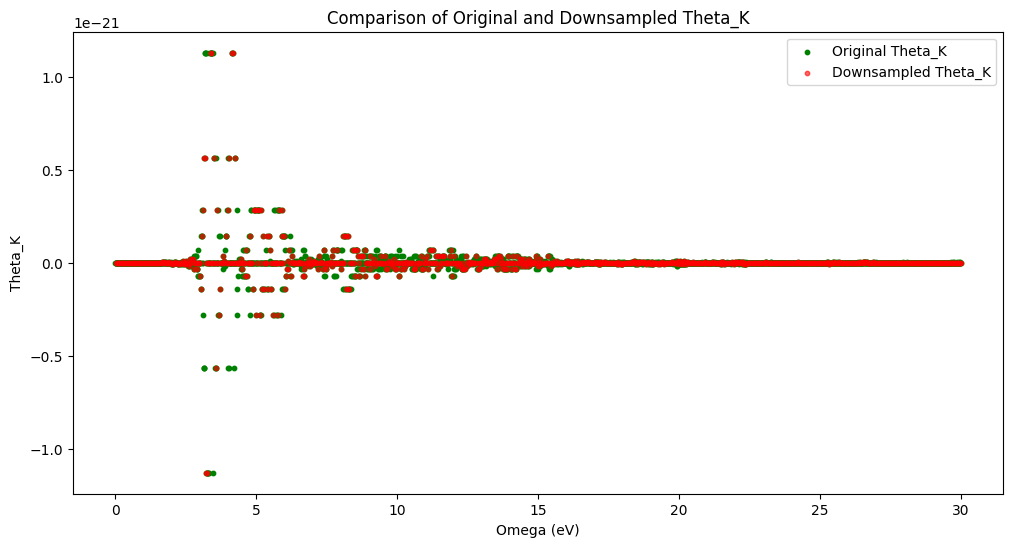

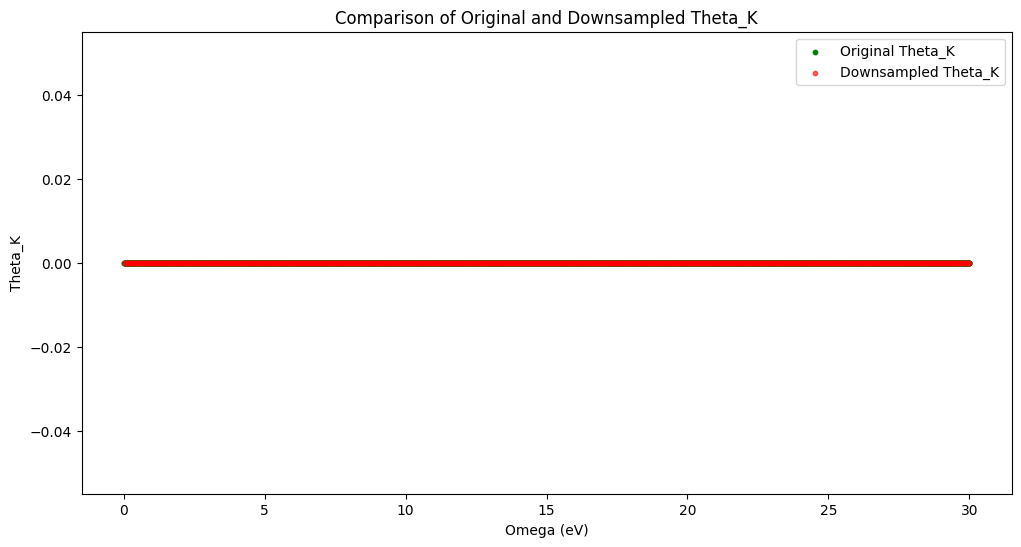

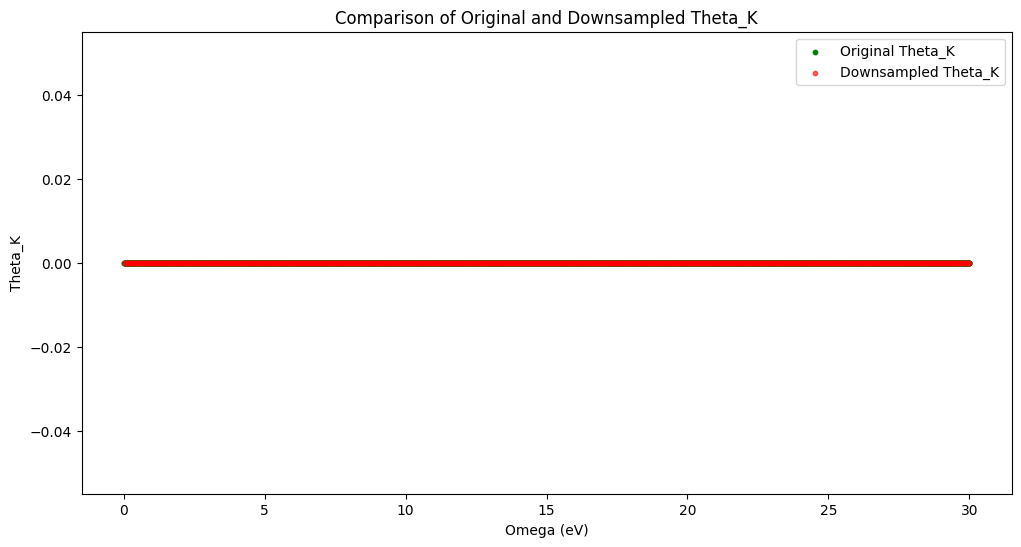

In [19]:
def plot_comparison(df):
    for _, row in df.iterrows():
        plt.figure(figsize=(12, 6))
        plt.scatter(row["omega"][1:], row["imag_symmetrized_permittivity"][1:,0,1], label="Original Theta_K", s=10, color='green')
        plt.scatter(new_x[1:], row["imag_Permittivity_Matrices_interp"][1:,0,1], label="Downsampled Theta_K", alpha=0.6, s=10, color='red')
        plt.xlabel("Omega (eV)")
        plt.ylabel("Theta_K")
        plt.legend()
        plt.title("Comparison of Original and Downsampled Theta_K")
        plt.show()

        # # Plot comparison for epsilon_K
        # plt.figure(figsize=(12, 6))
        # plt.scatter(row["omega"], row["epsilon_K_original"], label="Original Epsilon_K", s=10, color='green')
        # plt.scatter(new_x, row["epsilon_K_downsampled"], label="Downsampled Epsilon_K", alpha=0.6, s=10, color='red')
        # plt.xlabel("Omega (eV)")
        # plt.ylabel("Epsilon_K")
        # plt.legend()
        # plt.title("Comparison of Original and Downsampled Epsilon_K")
        # plt.show()
        
plot_comparison(df[df["crystal_system"] != "triclinic"].head(5))

